In [15]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

## Set up parameters, create isochrone grid

In [16]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F182M', 'jwst,F200W']
filters = ['m_jwst_F182M', 'm_jwst_F200W']
iso_dir = 'isochrones/'
metallicity = 0

# Select nbody6 simulation and snapshot, then convert to physical units and save as a cluster table which SPISEA can interface with

In [17]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma1.0/sfeff100_00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass         isMultiple        compMass             systemMass               e                log_a              age        
-------------------- ---------- ---------------------- -------------------- ------------------- ----------------- ------------------
  0.3869396973155288        0.0                     []   0.3869396973155288                 nan               nan 1.5099270103591411
0.037418754569603994        0.0                     [] 0.037418754569603994                 nan               nan 1.5099270103591411
 0.04340516993781862        0.0                     []  0.04340516993781862                 nan               nan  1.486613671283016
 0.04644362914842205        0.0                     []  0.04644362914842205                 nan               nan  1.486613671283016
                 ...        ...                    ...                  ...                 ...               ...                ...
 0.33350333854578423        1.0  [0.06989703019281274]  0.40340036873

# Read ages of stars, identify bracketing ages for isochrone generation
Also save mass of stars

In [18]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 6.171293394353679
Max log age = 6.181085893589938
Min level age = 1483519.9615441829
Max level age = 1517350.435256958


# Identify binary stars in cluster table, save mass of companion stars

Cluster table always lists binaries last, so finding the index of the first binary suffices

In [19]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
# print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
# print(compMasses)

# Generate isochrones using parameter and age arrays

In [20]:
increment = 0.5e6
start = (min(level_ages) // increment) * increment
end = (max(level_ages) // increment) * increment + 2 * increment

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[6.         6.17609126 6.30103   ]
[1000000. 1500000. 2000000.]


In [21]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

Isochrone generation took 1.024762 s.
Making photometry for isochrone: log(t) = 6.30  AKs = 0.00  dist = 410
     Starting at:  2024-04-15 23:59:01.804357   Usually takes ~5 minutes
Starting filter: jwst,F182M   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2235 K  m_jwst_F182M = 17.65
Starting filter: jwst,F200W   Elapsed time: 0.50 seconds
Starting synthetic photometry
M =   0.010 Msun  T =  2235 K  m_jwst_F200W = 17.49
      Time taken: 1.00 seconds
isochrone generation done


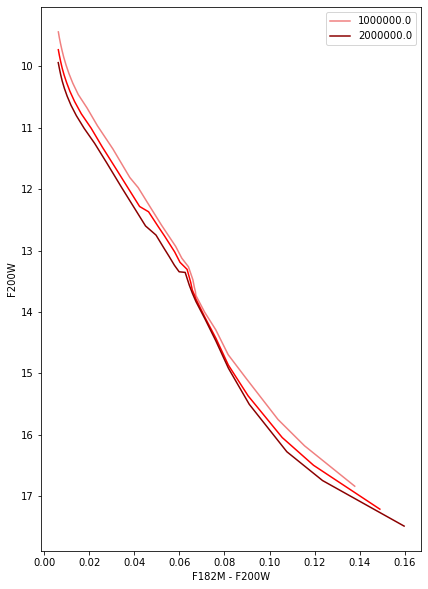

In [22]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
'''
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
'''
for i in range(len(log_age_arr)):
    if i == 0:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(log_age_arr) - 1:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'red', label='')
    
py.xlabel('F182M - F200W')
py.ylabel('F200W')
py.gca().invert_yaxis()
py.legend()

# Use generated SPISEA isochrones to find interpolated magnitudes using the age and mass of each star

Stars outside of the mass range of isochrones are thrown out and not included

In [23]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/')
import interpolator as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
# for i in range(len(stars)):
    # print(stars[i])

# Repeat interpolation on companion stars

Companion stars assumed to be the same age as primary star within system

In [24]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun


# Superimpose primary stars and companion stars against isochrones separately

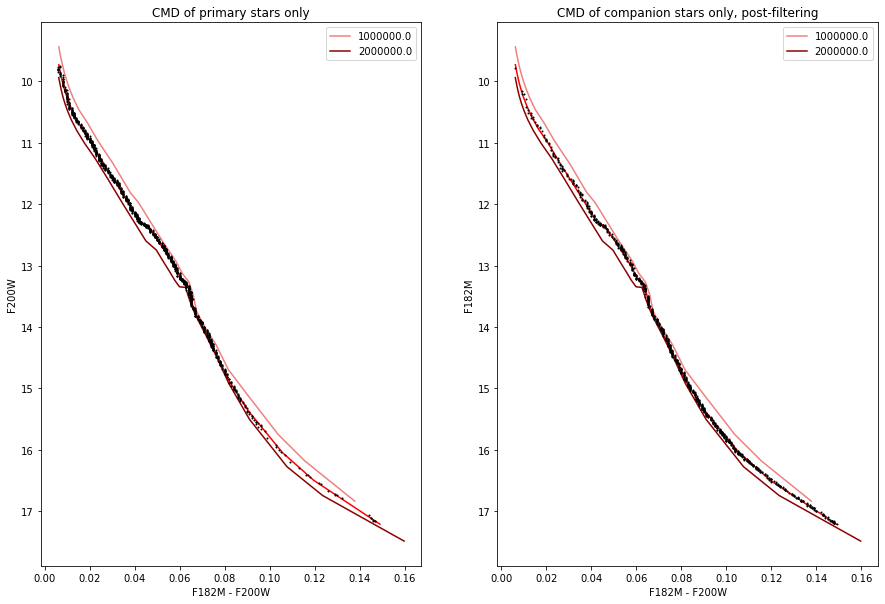

In [25]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)
for i in range(len(log_age_arr)):
    if i == 0:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(log_age_arr) - 1:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'red', label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F182M - F200W')
py.ylabel('F200W')
py.gca().invert_yaxis()
py.title('CMD of primary stars only')
py.legend()

# plot companions
py.subplot(1, 2, 2)
for i in range(len(log_age_arr)):
    if i == 0:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(log_age_arr) - 1:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'red', label='')
        
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F182M - F200W')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.title('CMD of companion stars only, post-filtering')
py.legend()

# Convert binary stars into unresolved binaries
## Also compute flux ratios of stars and generate histogram
Magnitudes of primary and secondary are converted into flux, which is used to find combined magnitude

In [26]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
    flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)
    
    unresolved_binaries[i] = [mag1, mag2]

# Generate CMD using star array, plus unresolved binaries
Compare to CMD generated by simply multiplying each star's flux by 2

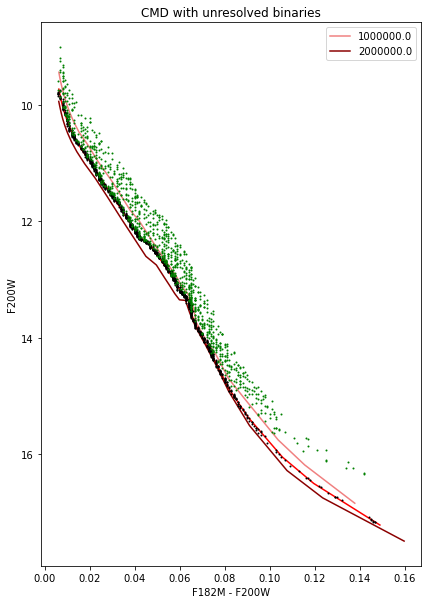

In [34]:
# plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)

for i in range(len(log_age_arr)):
    if i == 0:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(log_age_arr) - 1:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], 'red', label='')

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
            unresolved_binaries[i][1], marker='o', markersize=1, color='green')

py.xlabel('F182M - F200W')
py.ylabel('F200W')
py.gca().invert_yaxis()
py.title('CMD with unresolved binaries')
py.legend()

In [29]:
mags = []

count = 0
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    mags.append(stars[i][4])
    count = count + 1

for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    mags.append(unresolved_binaries[i][1])
    count = count + 1

print(count)

std = np.std(mags)
print("Standard deviation:" + str(std))

2314
Standard deviation:1.470792556460504
